# Modelling and Evaluation Notebook

## Objectives

Create a model to analyse OCT images to evaluate the condition of macula distingishing between 4 conditions: Normal, CNV, DNV, DRUSEN. This answers business requirement 2.

## Inputs

Data is divided in three folders: train, val, test with following paths:

1. inputs/OCTdata/train
2. inputs/OCTdata/val
3. inputs/OCTdata/test

Additionally, a pkl file with image shaping obtained in the image_visualisation notebook.

## Outputs

1. Images distribution plot in train, validation, and test set.
2. Image augmentation.
3. Class indices to change prediction inference in labels.
4. Machine learning model creation and training.
5. Save model.
6. Learning curve plot for model performance.
7. Model evaluation on pickle file.
8. Prediction on the random image file.




# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

## Set Working Directory

Finding the curent working directory

In [2]:
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader/jupiter_notebooks'

Moving it to the workspace directory

In [3]:
os.chdir('/workspace/OCTreader')
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader'

Now we define paths for the train, val, test folders

In [4]:
split_dirs = os.listdir('inputs/OCTdata')
split_paths = {
    split_dirs[0]: 'inputs/OCTdata/' + split_dirs[0],
    split_dirs[1]: 'inputs/OCTdata/' + split_dirs[1],
    split_dirs[2]: 'inputs/OCTdata/' + split_dirs[2]
}
labels = os.listdir(split_paths[split_dirs[0]])

## Set output folder path

In [4]:
version = 'v1'
output_path = f'outputs/{version}'

## Recall image shape

In [5]:
import joblib

image_shape = joblib.load(filename=f'{output_path}/image_shape.pkl')
image_shape

[170, 180, 3]

## Data availability

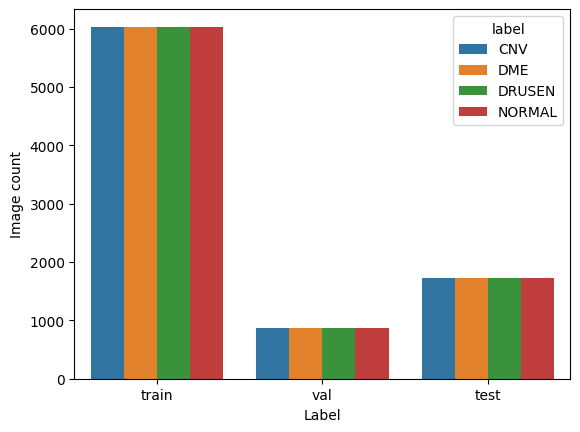

In [7]:
def data_availability_per_label(split_dir):
    '''
    Exploring the either train, val or test directoties
    counts the number of files per label

    '''
    df = pd.DataFrame(columns=['split_dir', 'label', 'count'])
    for label in labels:
        image_labels = os.listdir(split_paths[split_dir] + '/' + label)
        count = 0
        for image_name in image_labels:
            count += 1
        df = df.append({'split_dir': split_dir, 'label': label, 'count': count},
                       ignore_index=True)

    return df


def data_availability():
    df = pd.DataFrame(columns=['split_dir', 'label', 'count'])
    for split_dir in split_dirs:
        df2 = data_availability_per_label(split_dir)
        df = df.append(df2)
    ax = sns.barplot(data=df, x='split_dir', y='count', hue='label')
    ax.set(xlabel='Label', ylabel='Image count')
    plt.savefig(f'{output_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
    plt.show()


data_availability()

## Data Augmentation

### Creating ImageDataGenerator

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Train dataset augmentation

In [34]:
batch_size = 20

train_set = augmented_image_data.flow_from_directory(split_paths['train'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 24136 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

### Validation dataset augmentation

In [35]:
val_set = augmented_image_data.flow_from_directory(split_paths['val'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

val_set.class_indices

Found 3448 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

### Test dataset augmentation

In [36]:
test_set = augmented_image_data.flow_from_directory(split_paths['test'],
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

test_set.class_indices

Found 6896 images belonging to 4 classes.


{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

(20, 170, 180, 3)


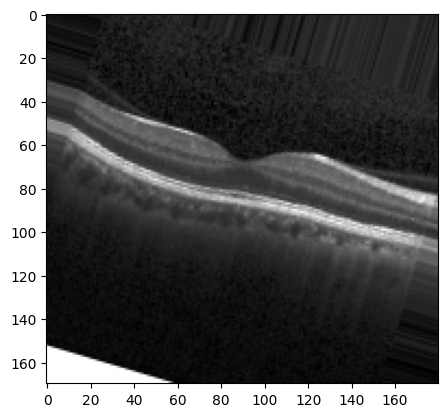

(20, 170, 180, 3)


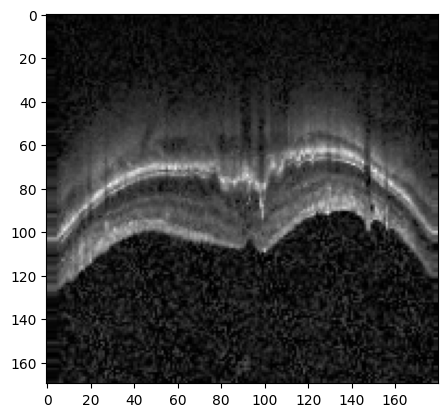

(20, 170, 180, 3)


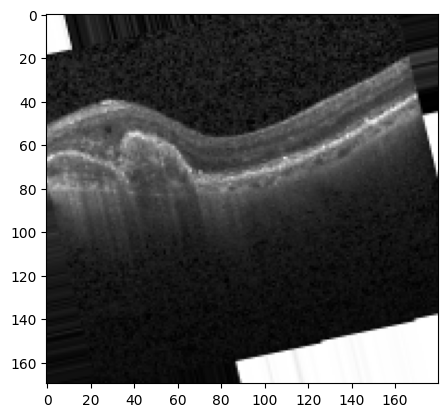

In [37]:
for i in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


## ML model

### Import model packages

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D


In [39]:
def create_multiclas_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))

    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### Print model summary

In [40]:
from tensorflow.keras.utils import plot_model
model = create_multiclas_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 168, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 84, 89, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 82, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 41, 43, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 39, 41, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 19, 20, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 24320)            

### Adding early stop

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
patience = 1
early_stop = EarlyStopping(monitor='val_loss', patience=patience)


# Fit model

In [42]:
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=val_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25
1206/1206 [==============================] - 646s 535ms/step - loss: 1.2272 - accuracy: 0.4091 - val_loss: 1.0147 - val_accuracy: 0.5519
Epoch 2/25
1206/1206 [==============================] - 700s 581ms/step - loss: 1.0014 - accuracy: 0.5600 - val_loss: 0.9553 - val_accuracy: 0.5928
Epoch 3/25
1206/1206 [==============================] - 734s 609ms/step - loss: 0.9394 - accuracy: 0.6012 - val_loss: 0.8946 - val_accuracy: 0.6180
Epoch 4/25
1206/1206 [==============================] - 822s 682ms/step - loss: 0.8950 - accuracy: 0.6312 - val_loss: 0.8614 - val_accuracy: 0.6337
Epoch 5/25
1206/1206 [==============================] - 761s 631ms/step - loss: 0.8461 - accuracy: 0.6558 - val_loss: 0.8167 - val_accuracy: 0.6691
Epoch 6/25
1206/1206 [==============================] - 819s 679ms/step - loss: 0.8072 - accuracy: 0.6819 - val_loss: 0.7439 - val_accuracy: 0.7050
Epoch 7/25
1206/1206 [==============================] - 796s 659ms/step - loss: 0.7730 - accuracy: 0.7002 - val_

### Save model

In [43]:
model.save('outputs/v1/OCTreader_model.h5')

## Model performance

### Model learning curves

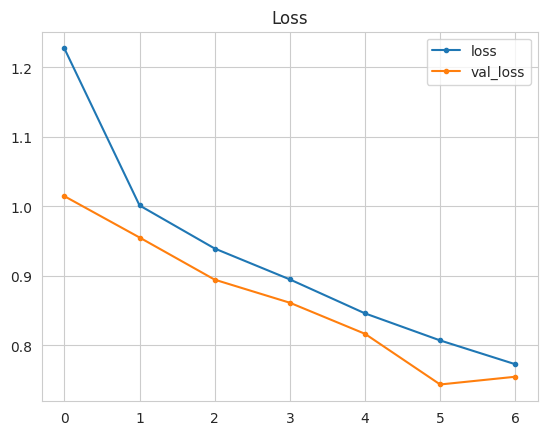

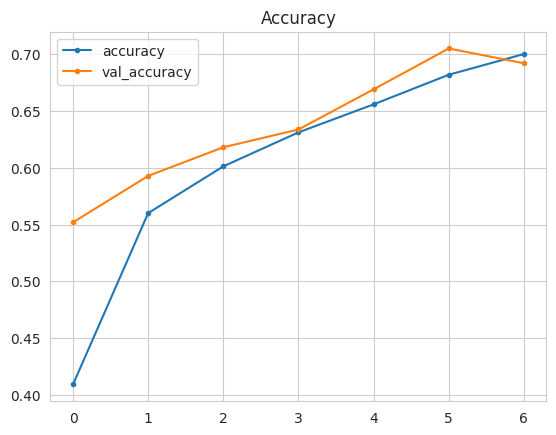

In [44]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'outputs/v1/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'outputs/v1/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model evaluation

### Uploading model

In [6]:
from keras.models import load_model
model = load_model('outputs/v1/OCTreader_model.h5')

2024-03-21 10:47:02.971266: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Evaluating using test dataset

In [32]:
evaluation = model.evaluate(test_set)

NameError: name 'test_set' is not defined

### Saving evaluation

In [47]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predicting data

### Load an image randomly

NORMAL
Image shape: (180, 170), Image mode: RGB


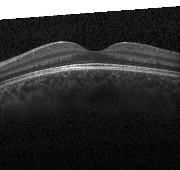

In [33]:
import random
from tensorflow.keras.preprocessing import image


test_path = split_paths['test']
labels = os.listdir(test_path)
my_label = random.choice(labels)
label_path = test_path + '/' + my_label
image_list = os.listdir(label_path)
random_image = random.choice(image_list)

print(my_label)
pred_image = image.load_img(label_path + '/' + random_image,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pred_image.size}, Image mode: {pred_image.mode}')
pred_image

### Image conversion to array

In [34]:
my_image = image.img_to_array(pred_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 170, 180, 3)


### Predicting class probability

In [35]:
target_map = {v: k for k, v in train_set.class_indices.items()}
target_map

NameError: name 'train_set' is not defined

In [36]:
pred_proba = model.predict(my_image)
max_prob_pos = np.argmax(pred_proba)

target_map = {v: k for k, v in train_set.class_indices.items()}
print(pred_proba)
print(target_map[max_prob_pos])


## Confusion matrix

### Create arrays for train, test and validation datasets

In [24]:
import random
from tensorflow.keras.preprocessing import image

def create_dataset_image_array(split_dir, n_images):
    X, y = np.array([], dtype='int'), np.array([], dtype='int')
    labels = os.listdir(split_dir)
    n_label = 0
    for label in labels:
        label_path = split_dir + '/' + label
        full_image_list = os.listdir(label_path)
        image_list = full_image_list[0: n_images]
        random.shuffle(image_list)
        for image_name in image_list:
            img = image.load_img(f'{label_path}/{image_name}', target_size=image_shape[:2])
            img_array = image.img_to_array(img)
            if img_array.max()>1:
                resized_img = img_array / 255
            else:
                resized_img = img_array
            
            X = np.append(X, resized_img).reshape(-1, image_shape[0], image_shape[1], 3)
            y = np.append(y, n_label)
        n_label += 1
    return X, y

# X_train, y_train = create_dataset_image_array('inputs/OCTdata/train', 100)
X_val, y_val = create_dataset_image_array('inputs/OCTdata/val', 100)
# X_test, y_test = create_dataset_image_array('inputs/OCTdata/test', 100)


### Preparing for prediction function

In [27]:

pred_proba = model.predict(X_val)

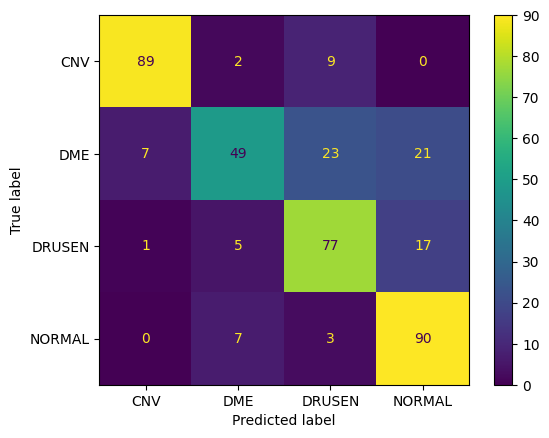

In [36]:
from sklearn import metrics
import matplotlib.pyplot as plt


prediction = np.argmax(pred_proba, axis=1)



confusion_matrix = metrics.confusion_matrix(y_val, prediction)
# print(metrics.classification_report(y_val, prediction))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=['CNV', 'DME', 'DRUSEN', 'NORMAL'])
cm_display.plot()
plt.show()
